# Enhanced Data Exploration and Visualization

## Overview
This notebook provides comprehensive data exploration and visualization for the student dropout prediction project. It includes advanced statistical analysis, demographic insights, and performance comparisons.

## Objectives
- **Comprehensive Data Exploration**: Deep dive into dataset characteristics and patterns
- **Advanced Visualizations**: Create meaningful charts and graphs for data interpretation
- **Demographic Analysis**: Examine student demographics and their impact on outcomes
- **Performance Metrics**: Detailed analysis of academic performance patterns
- **Statistical Insights**: Generate actionable insights from data patterns

## Key Features
- Enhanced nationality analysis with filtering
- Feature importance analysis using multiple methods
- Comprehensive model evaluation with visualizations
- Academic performance analysis across different student groups
- Multi-model comparison and validation

---


Cell 0 (Import Libraries) - Add additional libraries for enhanced analysis:


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Try to import XGBoost, but continue if not available
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    print("XGBoost not available, skipping XGBoost model")
    xgboost_available = False

XGBoost not available, skipping XGBoost model


Cell 3 or 4 (Data Loading) - Filter nationalities with fewer than 5 students:


In [5]:
# Load the data with correct separator
df = pd.read_csv('data.csv', sep=';')

# Clean column names
df.columns = df.columns.str.strip()

# Count nationalities
nationality_counts = df['Nacionality'].value_counts()

# Keep only nationalities with at least 5 students
valid_nationalities = nationality_counts[nationality_counts >= 5].index
df_filtered = df[df['Nacionality'].isin(valid_nationalities)]

# Print filtering statistics
print(f"Original number of nationalities: {len(nationality_counts)}")
print(f"Valid nationalities (≥5 students): {len(valid_nationalities)}")
print(f"Removed nationalities: {len(nationality_counts) - len(valid_nationalities)}")
print(f"Percentage of nationalities removed: {(len(nationality_counts) - len(valid_nationalities)) / len(nationality_counts) * 100:.2f}%")
print(f"Students in filtered dataset: {len(df_filtered)}")
print(f"Percentage of students retained: {len(df_filtered) / len(df) * 100:.2f}%")

# Use the filtered dataset for analysis
df = df_filtered

Original number of nationalities: 21
Valid nationalities (≥5 students): 6
Removed nationalities: 15
Percentage of nationalities removed: 71.43%
Students in filtered dataset: 4397
Percentage of students retained: 99.39%


Add Enhanced Visualization Cell - After the nationality analysis (cell 10):


<Figure size 1400x800 with 0 Axes>

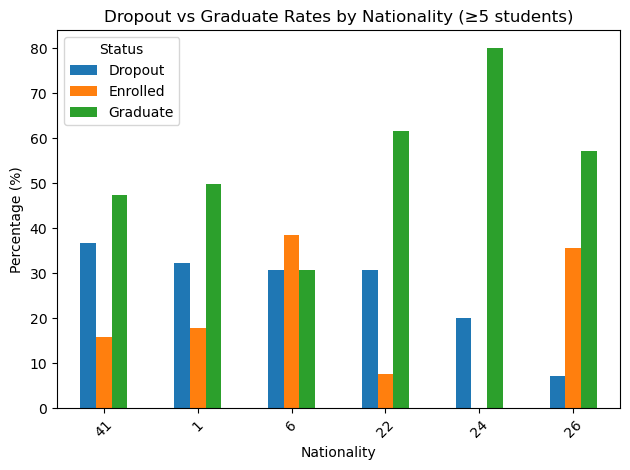

Statistics for nationalities with ≥5 students:
             Total  Dropout_Count  Graduate_Count  Dropout_Rate  Graduate_Rate
Nacionality                                                                   
41              38             14              18     36.842105      47.368421
1             4314           1389            2155     32.197497      49.953639
6               13              4               4     30.769231      30.769231
22              13              4               8     30.769231      61.538462
24               5              1               4     20.000000      80.000000
26              14              1               8      7.142857      57.142857


In [6]:
# Enhanced visualization for nationality analysis
plt.figure(figsize=(14, 8))

# Create filtered crosstab only including nationalities with 5+ students
nationality_target = pd.crosstab(df['Nacionality'], df['Target'])
nationality_target['Total'] = nationality_target.sum(axis=1)

# Calculate percentage
nationality_pct = pd.crosstab(df['Nacionality'], df['Target'], normalize='index') * 100

# Sort by dropout rate
dropout_rate = nationality_pct['Dropout'].sort_values(ascending=False)

# Plot the top 10 nationalities with highest dropout rates
top_nationalities = dropout_rate.head(10).index
nationality_pct.loc[top_nationalities].plot(kind='bar', stacked=False)

plt.title('Dropout vs Graduate Rates by Nationality (≥5 students)')
plt.xlabel('Nationality')
plt.ylabel('Percentage (%)')
plt.legend(title='Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print statistics for each nationality
print("Statistics for nationalities with ≥5 students:")
stats_df = pd.DataFrame({
    'Total': nationality_target['Total'],
    'Dropout_Count': nationality_target['Dropout'],
    'Graduate_Count': nationality_target['Graduate'],
    'Dropout_Rate': nationality_pct['Dropout'],
    'Graduate_Rate': nationality_pct['Graduate']
})
print(stats_df.sort_values('Dropout_Rate', ascending=False))

Add a Feature Importance Cell - Add after model training:


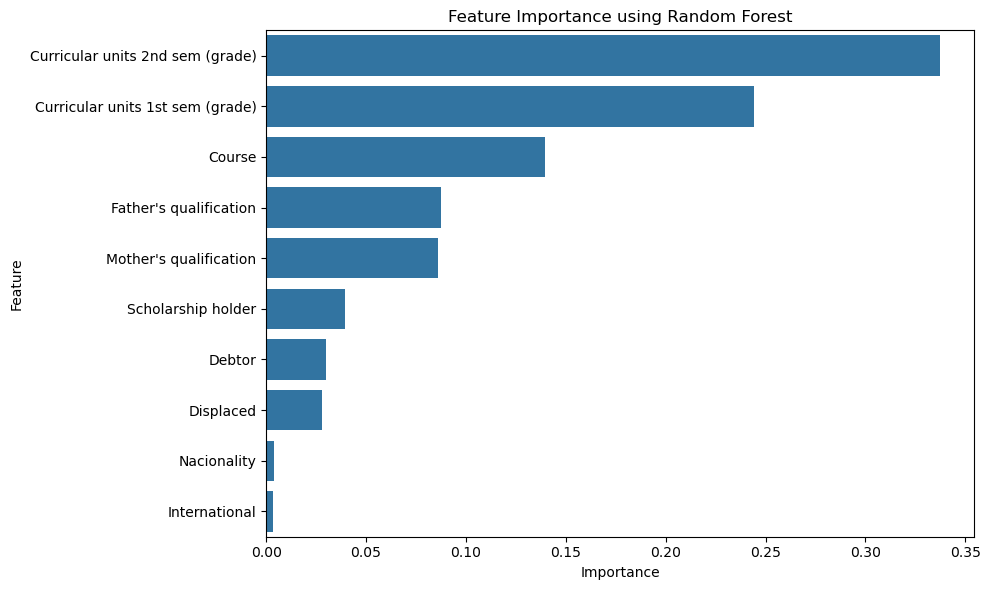

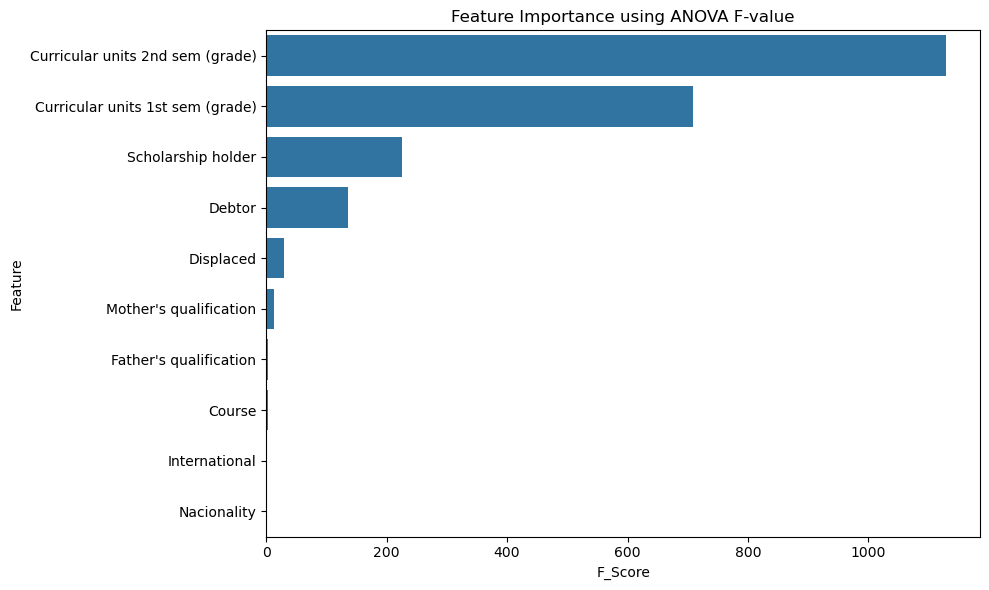

Feature Importance using Random Forest:
                            Feature  Importance
9  Curricular units 2nd sem (grade)    0.337515
8  Curricular units 1st sem (grade)    0.244283
1                            Course    0.139664
5            Father's qualification    0.087750
4            Mother's qualification    0.085836
0                Scholarship holder    0.039332
7                            Debtor    0.030171
6                         Displaced    0.028195
2                       Nacionality    0.004027
3                     International    0.003227

Feature Importance using ANOVA F-value:
                            Feature      F_Score
9  Curricular units 2nd sem (grade)  1128.826240
8  Curricular units 1st sem (grade)   708.635283
0                Scholarship holder   224.735158
7                            Debtor   136.710078
6                         Displaced    29.086172
4            Mother's qualification    12.521858
5            Father's qualification     3.358672

In [7]:
# Feature Importance Analysis using Random Forest
features = [
    'Scholarship holder',
    'Course',
    'Nacionality',
    'International',
    "Mother's qualification",
    "Father's qualification",
    'Displaced',
    'Debtor',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (grade)'
]

# Prepare data
X = df[features]
y = df['Target']

# Encode categorical columns
le = LabelEncoder()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = le.fit_transform(X[col])

# Train Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance using Random Forest')
plt.tight_layout()
plt.show()

# ANOVA F-value for feature importance
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
anova_scores = pd.DataFrame({
    'Feature': features,
    'F_Score': selector.scores_
}).sort_values('F_Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='F_Score', y='Feature', data=anova_scores)
plt.title('Feature Importance using ANOVA F-value')
plt.tight_layout()
plt.show()

print("Feature Importance using Random Forest:")
print(feature_importance)
print("\nFeature Importance using ANOVA F-value:")
print(anova_scores)

Add Enhanced Model Evaluation Cell - Add after existing model training:


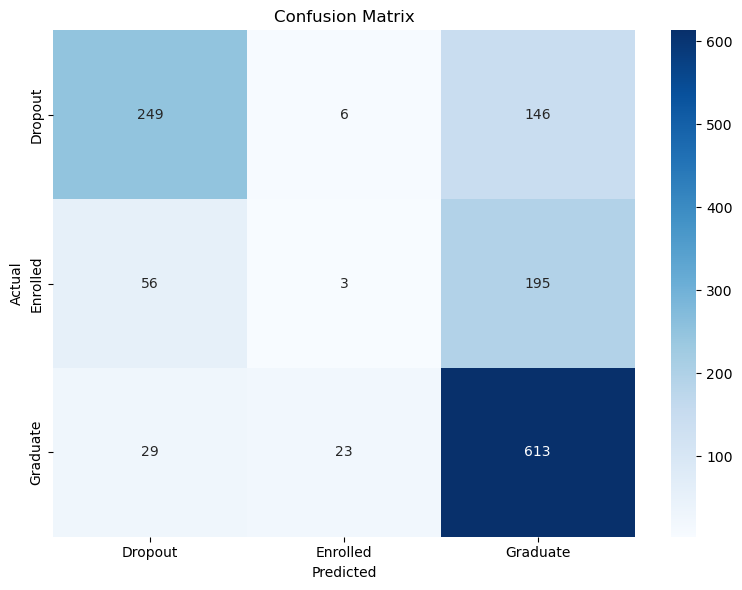


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.75      0.62      0.68       401
    Enrolled       0.09      0.01      0.02       254
    Graduate       0.64      0.92      0.76       665

    accuracy                           0.66      1320
   macro avg       0.49      0.52      0.49      1320
weighted avg       0.57      0.66      0.59      1320

Cross-Validation Scores: [0.64772727 0.65227273 0.67463026 0.64618885 0.67918089]
Mean CV Score: 0.660
Standard Deviation: 0.014


In [9]:
# Enhanced Model Evaluation with Confusion Matrix, ROC Curve, and Cross-Validation
# Train Gaussian Naive Bayes model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

# Get unique classes
classes = np.unique(np.concatenate([y_test, y_pred]))
n_classes = len(classes)

# Confusion Matrix with detailed annotations
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Use actual class names if available, otherwise use indices
if hasattr(gnb, 'classes_'):
    class_names = gnb.classes_
else:
    class_names = [str(i) for i in range(n_classes)]
    
plt.xticks(np.arange(n_classes) + 0.5, class_names)
plt.yticks(np.arange(n_classes) + 0.5, class_names)

plt.tight_layout()
plt.show()

# Calculate and print metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC curve for binary classification only
if n_classes == 2 and hasattr(gnb, 'predict_proba'):
    y_pred_proba = gnb.predict_proba(X_test)[:, 1]  # Probability for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(gnb, X, y, cv=cv)

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.3f}")
print(f"Standard Deviation: {cv_scores.std():.3f}")

Add Academic Performance Analysis Cell - Add new cell for analyzing academic patterns:


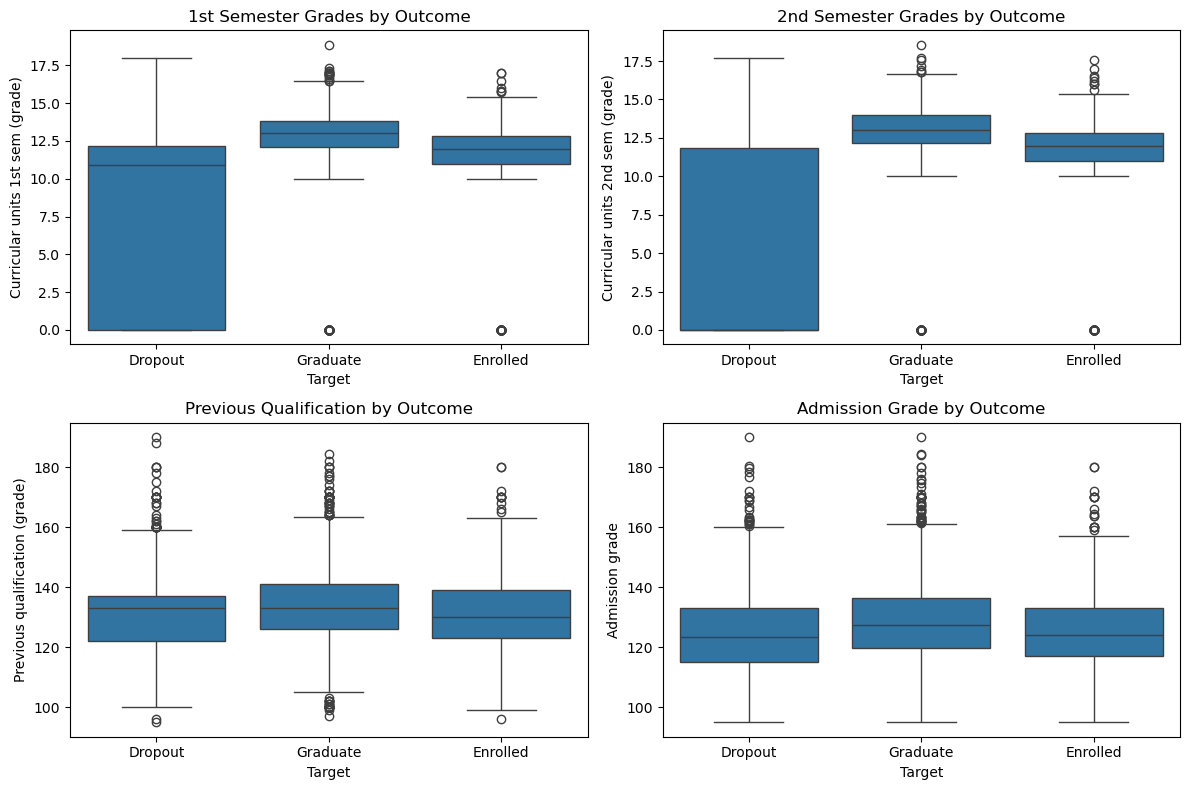

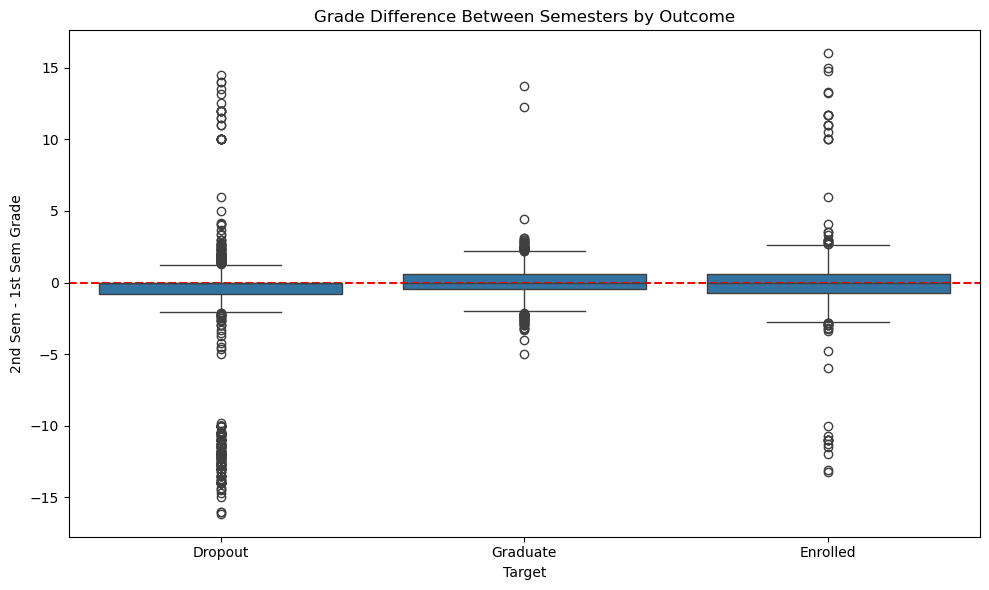

Academic Performance Statistics by Outcome:
         Curricular units 1st sem (grade)               \
                                     mean median   std   
Target                                                   
Dropout                              7.25   10.9  6.03   
Enrolled                            11.12   12.0  3.69   
Graduate                            12.64   13.0  2.70   

         Curricular units 2nd sem (grade)               \
                                     mean median   std   
Target                                                   
Dropout                              5.89    0.0  6.12   
Enrolled                            11.13   12.0  3.59   
Graduate                            12.69   13.0  2.69   

         Previous qualification (grade)               Admission grade         \
                                   mean median    std            mean median   
Target                                                                         
Dropout           

In [10]:
# Academic Performance Analysis
plt.figure(figsize=(12, 8))

# Create subplots for academic metrics
plt.subplot(2, 2, 1)
sns.boxplot(x='Target', y='Curricular units 1st sem (grade)', data=df)
plt.title('1st Semester Grades by Outcome')

plt.subplot(2, 2, 2)
sns.boxplot(x='Target', y='Curricular units 2nd sem (grade)', data=df)
plt.title('2nd Semester Grades by Outcome')

plt.subplot(2, 2, 3)
sns.boxplot(x='Target', y='Previous qualification (grade)', data=df)
plt.title('Previous Qualification by Outcome')

plt.subplot(2, 2, 4)
sns.boxplot(x='Target', y='Admission grade', data=df)
plt.title('Admission Grade by Outcome')

plt.tight_layout()
plt.show()

# Calculate grade differences between semesters
df['Grade_Difference'] = df['Curricular units 2nd sem (grade)'] - df['Curricular units 1st sem (grade)']

plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='Grade_Difference', data=df)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Grade Difference Between Semesters by Outcome')
plt.ylabel('2nd Sem - 1st Sem Grade')
plt.tight_layout()
plt.show()

# Calculate statistics
grade_stats = df.groupby('Target')[[
    'Curricular units 1st sem (grade)', 
    'Curricular units 2nd sem (grade)', 
    'Previous qualification (grade)', 
    'Admission grade',
    'Grade_Difference'
]].agg(['mean', 'median', 'std']).round(2)

print("Academic Performance Statistics by Outcome:")
print(grade_stats)

Add Comprehensive Model Comparison Cell - Add for comparing multiple models:


XGBoost not available, skipping XGBoost model


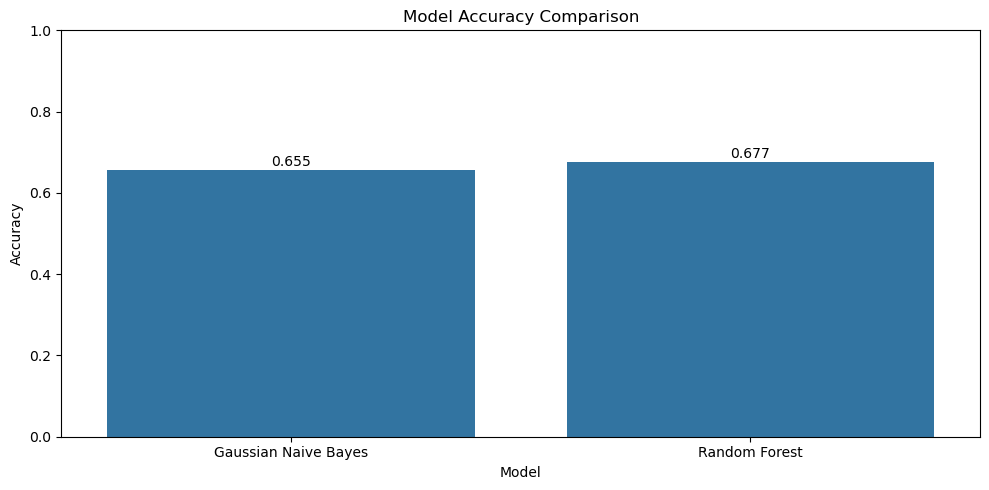


Gaussian Naive Bayes Results:
Accuracy: 0.655
Mean CV Score: 0.656
F1-Score (macro): 0.485
Confusion Matrix:
[[249   6 146]
 [ 56   3 195]
 [ 29  23 613]]

Random Forest Results:
Accuracy: 0.677
Mean CV Score: 0.684
F1-Score (macro): 0.571
Confusion Matrix:
[[266  31 104]
 [ 70  47 137]
 [ 42  43 580]]


In [12]:
# Comprehensive Model Comparison

# Check if XGBoost is available
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    print("XGBoost not available, skipping XGBoost model")
    xgboost_available = False

# Define models
models = {
    'Gaussian Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Add XGBoost if available
if xgboost_available:
    models['XGBoost'] = xgb.XGBClassifier(random_state=42)

# Prepare data
X = df[features]
y = df['Target']

# Encode categorical variables
for col in X.select_dtypes(include=['object']).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = (y_pred == y_test).mean()
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5)
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
        'Classification Report': report,
        'CV Scores': cv_scores
    }

# Plot accuracy comparison
accuracies = [results[name]['Accuracy'] for name in models.keys()]
plt.figure(figsize=(10, 5))
sns.barplot(x=list(models.keys()), y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center')
plt.tight_layout()
plt.show()

# Print detailed results
for name, result in results.items():
    print(f"\n{name} Results:")
    print(f"Accuracy: {result['Accuracy']:.3f}")
    print(f"Mean CV Score: {result['CV Scores'].mean():.3f}")
    try:
        print(f"F1-Score (macro): {result['Classification Report']['macro avg']['f1-score']:.3f}")
    except KeyError:
        print("F1-Score not available")
    print(f"Confusion Matrix:")
    print(result['Confusion Matrix'])